In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


**Business Understanding**

Credit Card Fraud Detection is a classic imblance issue where the happening of the fraud transaction is much less than the legitimate transaction among any bank.
To approach such imbalanced data for building prediction models, it typically fails to generate real-time results because of overfitting on training data and a bias towards the majority of legitimate transactions. 

**Analysis Purpose**

Credit card companies need to detect fraudulent as well as adnormal transactions to prevent customers from being charged for unauthorized purchases.

**Expected Findings**

* What time does the Credit Card Frauds usually take place?
* What are the general trends of amounts for Credit Card Fraud Transactions?
* How do we balance the data to not let the model overfit on legitimate transactions?

**Exploratory Data Analysis (EDA)**

* The Data has 32 features from V1-V28 which are unknown for confidentiality. Included: Time, Amount and Class.
* The input features are V1-V28, Time and Amount.
* The target variable is Class.
* The Data does not have any missing values as evident from the below mentioned code, thus need not be handled.
* The Data consists of all numerical features, and only the Target Variable Class is a categorical feature.
* Class 0: Legitimate Transaction (total amount: 284,315)
* Class 1: Fraud Transaction (total amount: 492)

In [36]:
# Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

from mlxtend.plotting import plot_learning_curves
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

In [37]:
#Read the CSV file
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv') 

In [38]:
#Display the 1st to 5th rows of the DataFrame(df)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [39]:
#Summary of the DataFrame(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [40]:
#Classify the amount of  legitimate transactions and fraudulent transactions
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

<Axes: xlabel='Class', ylabel='count'>

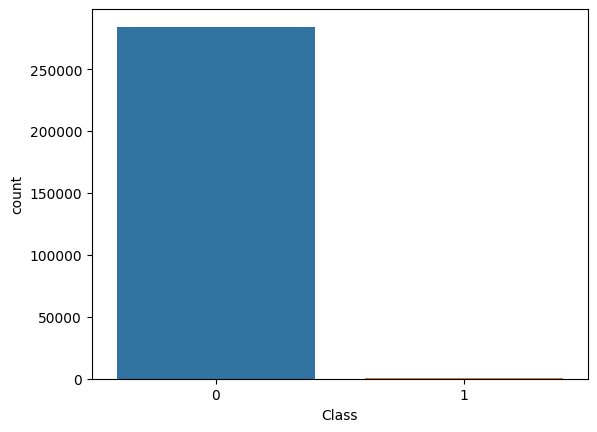

In [41]:
# Create a count plot to visualize the distribution of classes in the 'Class' column of the DataFrame(df)
sns.countplot(x='Class', data=df)

**Insight**
* According to the count plot, it is obviously that the dataset is highly imbalanced, with the majority of class label '0' and the minority of class label '1'.

**Data Pre-processing**

In [42]:
# Calculate the correlation between the 'Class' column and the first 30 columns 
x = df.corr()['Class'][:30]
print(x)

Time     -0.01
V1       -0.10
V2        0.09
V3       -0.19
V4        0.13
V5       -0.09
V6       -0.04
V7       -0.19
V8        0.02
V9       -0.10
V10      -0.22
V11       0.15
V12      -0.26
V13      -0.00
V14      -0.30
V15      -0.00
V16      -0.20
V17      -0.33
V18      -0.11
V19       0.03
V20       0.02
V21       0.04
V22       0.00
V23      -0.00
V24      -0.01
V25       0.00
V26       0.00
V27       0.02
V28       0.01
Amount    0.01
Name: Class, dtype: float64


<Axes: title={'center': 'Correlation of Features with Target Variable'}>

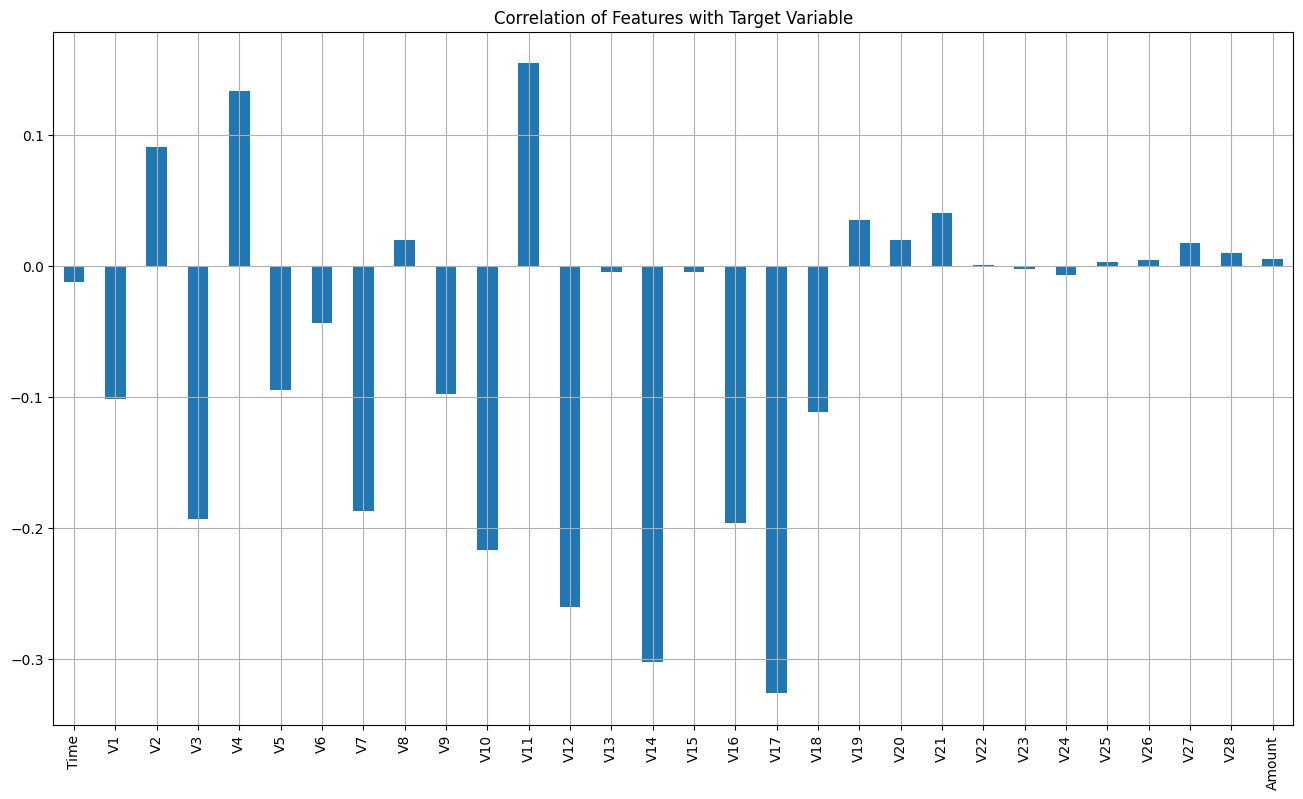

In [43]:
#Calculate the correlation coefficients between the 'Class' column and the first 30 columns
x = df.corr()['Class'][:30]

# Create a bar plot to visualize the correlation of features with the target variable 'Class'
x.plot.bar(figsize=(16, 9), title = 'Correlation of Features with Target Variable', grid = True)

Perform the intercorrelation among variables.

<Axes: >

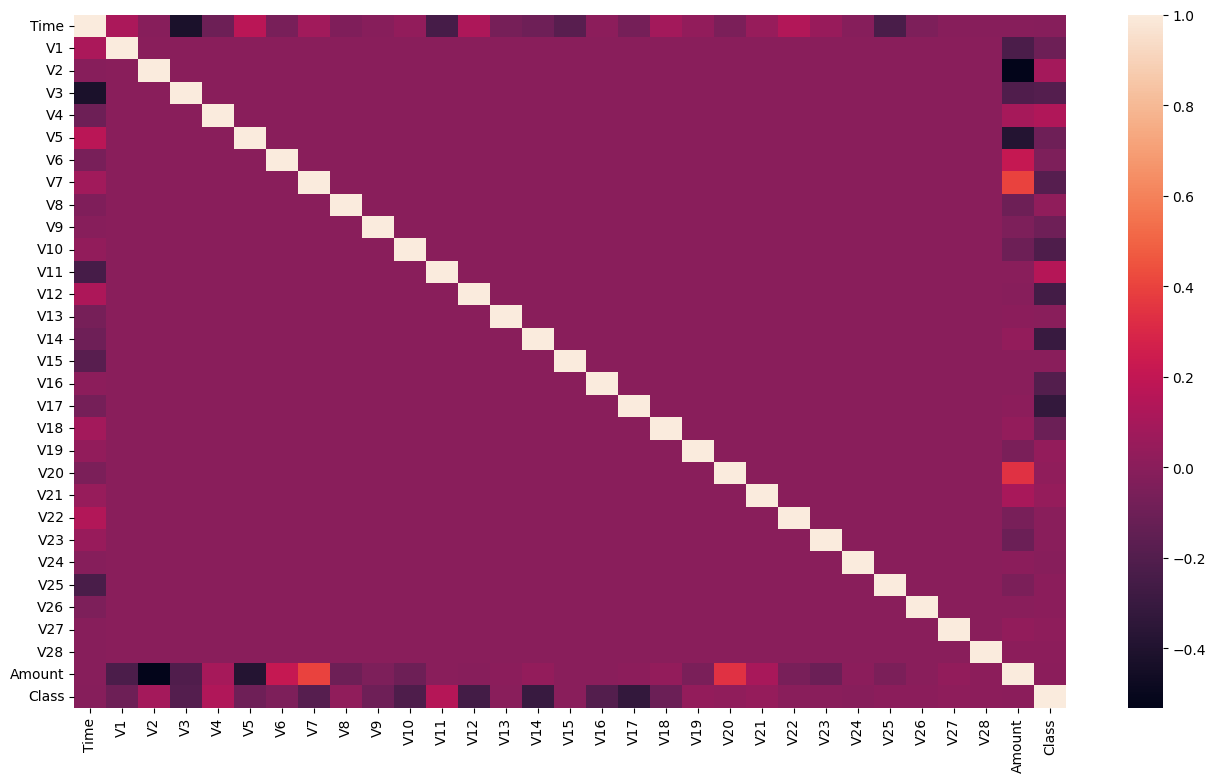

In [44]:
# Create a figure with a specific size for the heatmap
plt.figure(figsize=(16, 9))

# Create a heatmap to visualize the correlation matrix of the DataFrame df
sns.heatmap(df.corr())

**Insight**
* The only intercorrelated variable among others is the label 'Amount'. 
* However, this variable shows no correlation with the target variable, so 'Amount' will be removed.

In [45]:
# Calculate the correlation coefficients between 'Class' and ALL columns
y = df.corr()['Class']

# Create a copy of the DataFrame(df)
df2 = df.copy()

# Iterate through columns and drop those with absolute correlation less than 0.13
# Keep only features with a correlation above 0.13.
for i in df.columns:
    if abs(y[i]) < 0.13:
        df2.drop(columns=[i], inplace=True)

In [46]:
# Display the first few rows of the DataFrame df2
df2.head()

,V3,V4,V7,V10,V11,V12,V14,V16,V17,Class
0,2.54,1.38,0.24,0.09,-0.55,-0.62,-0.31,-0.47,0.21,0
1,0.17,0.45,-0.08,-0.17,1.61,1.07,-0.14,0.46,-0.11,0
2,1.77,0.38,0.79,0.21,0.62,0.07,-0.17,-2.89,1.11,0
3,1.79,-0.86,0.24,-0.05,-0.23,0.18,-0.29,-1.06,-0.68,0
4,1.55,0.40,0.59,0.75,-0.82,0.54,-1.12,-0.45,-0.24,0


<Axes: >

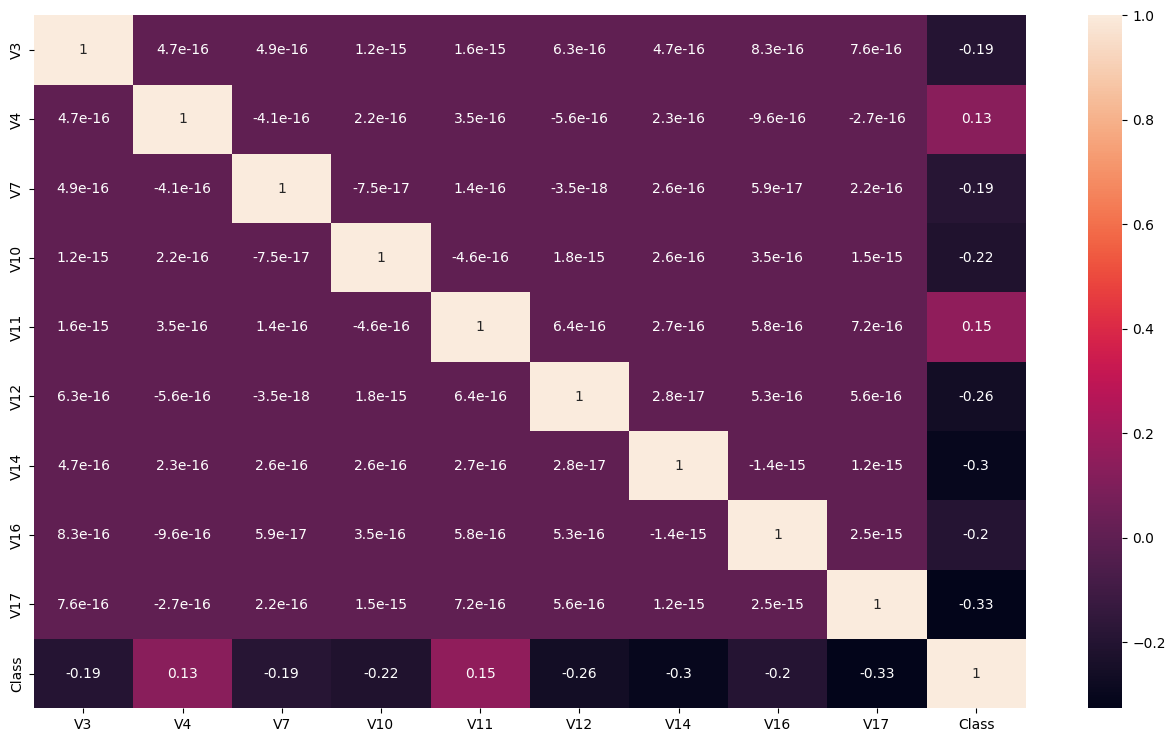

In [47]:
# Create a figure with a specific size for the heatmap
plt.figure(figsize=(16, 9))

# Create a heatmap to visualize the correlation matrix of the DataFrame df2
sns.heatmap(df2.corr(), annot=True)

<Axes: title={'center': 'Top Correlated Features With The Target Variable'}>

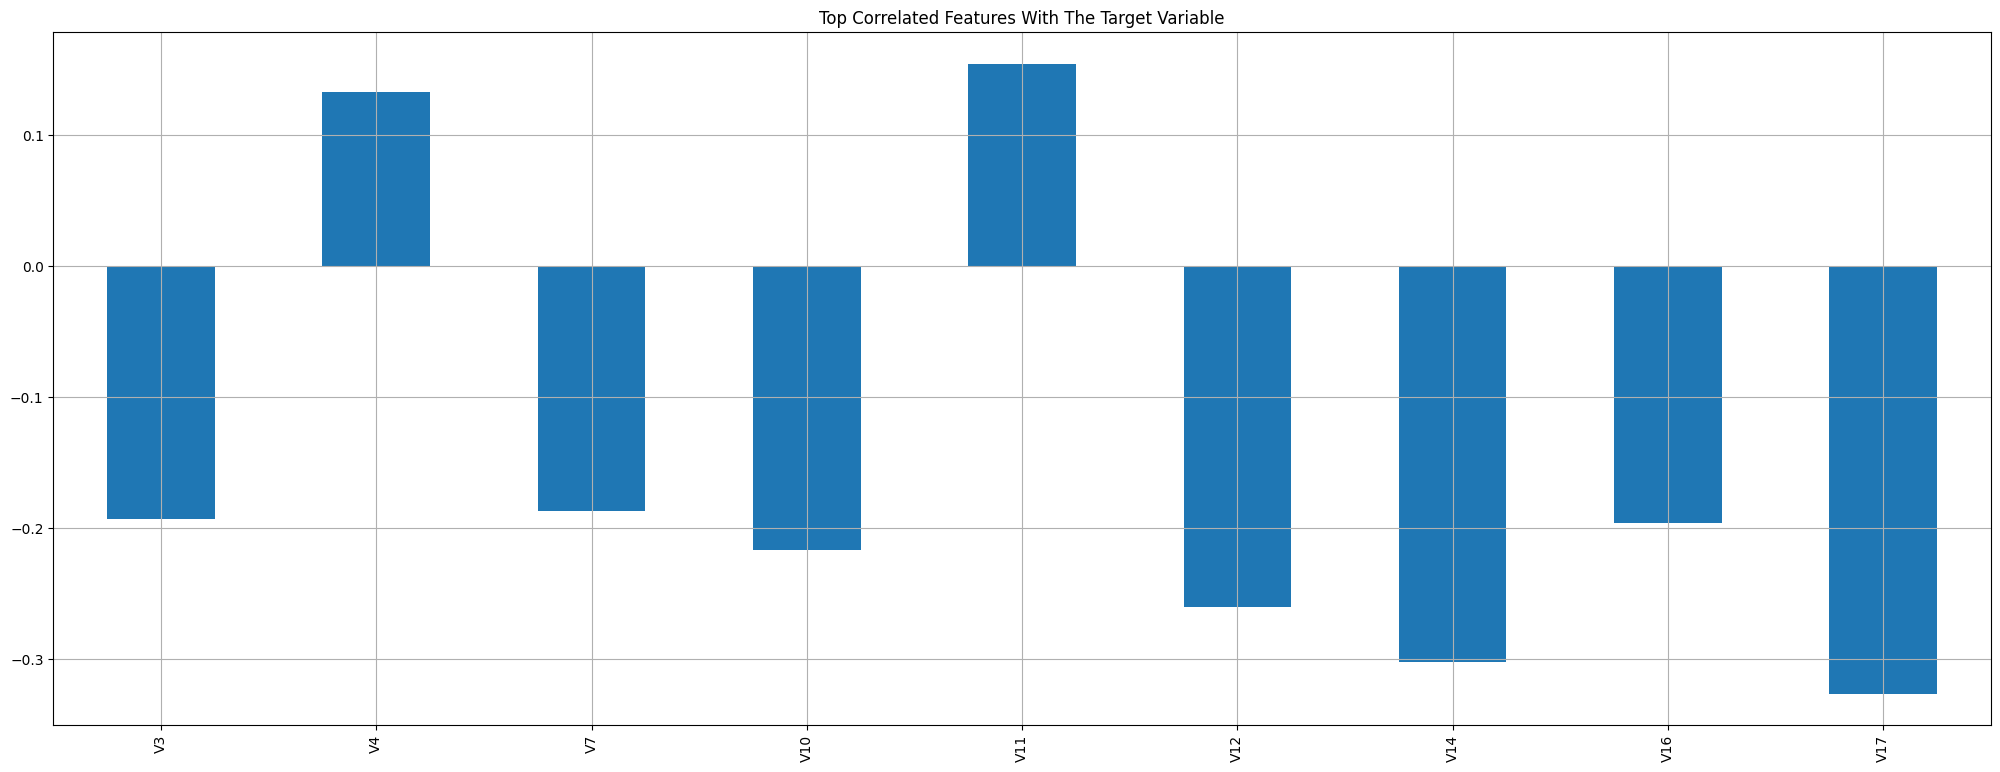

In [48]:
# Calculate the correlation coefficients between the 'Class' column 
x = df2.corr()['Class'][:9]

# Create a bar plot to visualize the top correlated features with the target variable 'Class'
x.plot.bar(figsize=(25, 9), title="Top Correlated Features With The Target Variable", grid=True)

**Resolve Data Imblance**

This dataset consists of:
* Number of records with the class value 0: 284,315
* Number of records with the class value 1: 492

To address a fatal mistake due to the severe class imblance, it is suitable to use **downsampling** method.
* Oversampling(SMOTE, Synthetic Minority Over-sampling Technique): Although it is High Accuracy, it leads to high false positives, because of synthetic examples. Therefore, the consequence turn out to be overfitting and recued precision.

In [49]:
# Perform downsampling process
from imblearn.under_sampling import RandomUnderSampler

# Separate features(X) and target(y)
X = df2.drop('Class', axis=1)
y = df2['Class']

# Activate RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Fit and apply the resampler to the data
X_resampled, y_resampled = rus.fit_resample(X, y)

# Convert the resampled data back to a DataFrame
downsampled_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Class'])], axis=1)

downsampled_df.head()

,V3,V4,V7,V10,V11,V12,V14,V16,V17,Class
138028,-0.67,0.72,0.39,-0.60,-0.33,-0.22,-1.05,0.60,0.63,0
63099,0.90,0.69,0.50,0.17,0.82,0.47,0.57,-0.01,-0.50,0
73411,1.12,-1.31,-0.70,2.05,0.58,-0.59,-0.34,-0.76,0.54,0
164247,-0.99,-0.03,0.78,-1.24,-0.84,-0.59,-0.44,0.27,0.70,0
148999,0.27,3.87,-0.72,1.17,1.30,-1.92,1.32,1.32,-0.44,0


In [50]:
#Display the shape of the downsampled DataFrame downsampled_df
downsampled_df.shape

(984, 10)

**Check if it has Outliers**

<Axes: xlabel='Class', ylabel='count'>

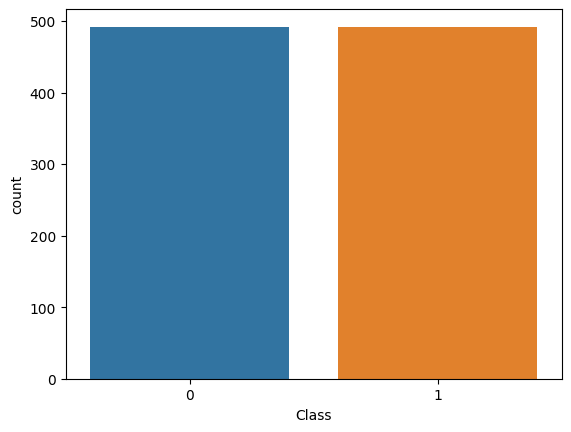

In [51]:
# Create a count plot to visualize the distribution of classes in the 'Class' column of the downsampled DataFrame downsampled_df
sns.countplot(x='Class', data=downsampled_df)

**Insight**

Data is balanced

<Axes: xlabel='V11', ylabel='V17'>

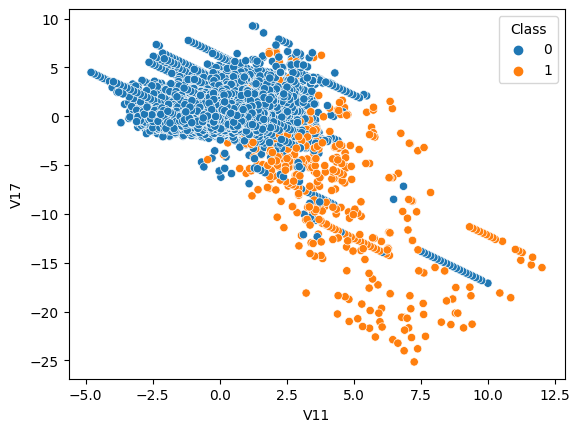

In [52]:
# Plotting using seaborn scatterplot
sns.scatterplot(x='V11', y='V17', hue='Class', data=df2)

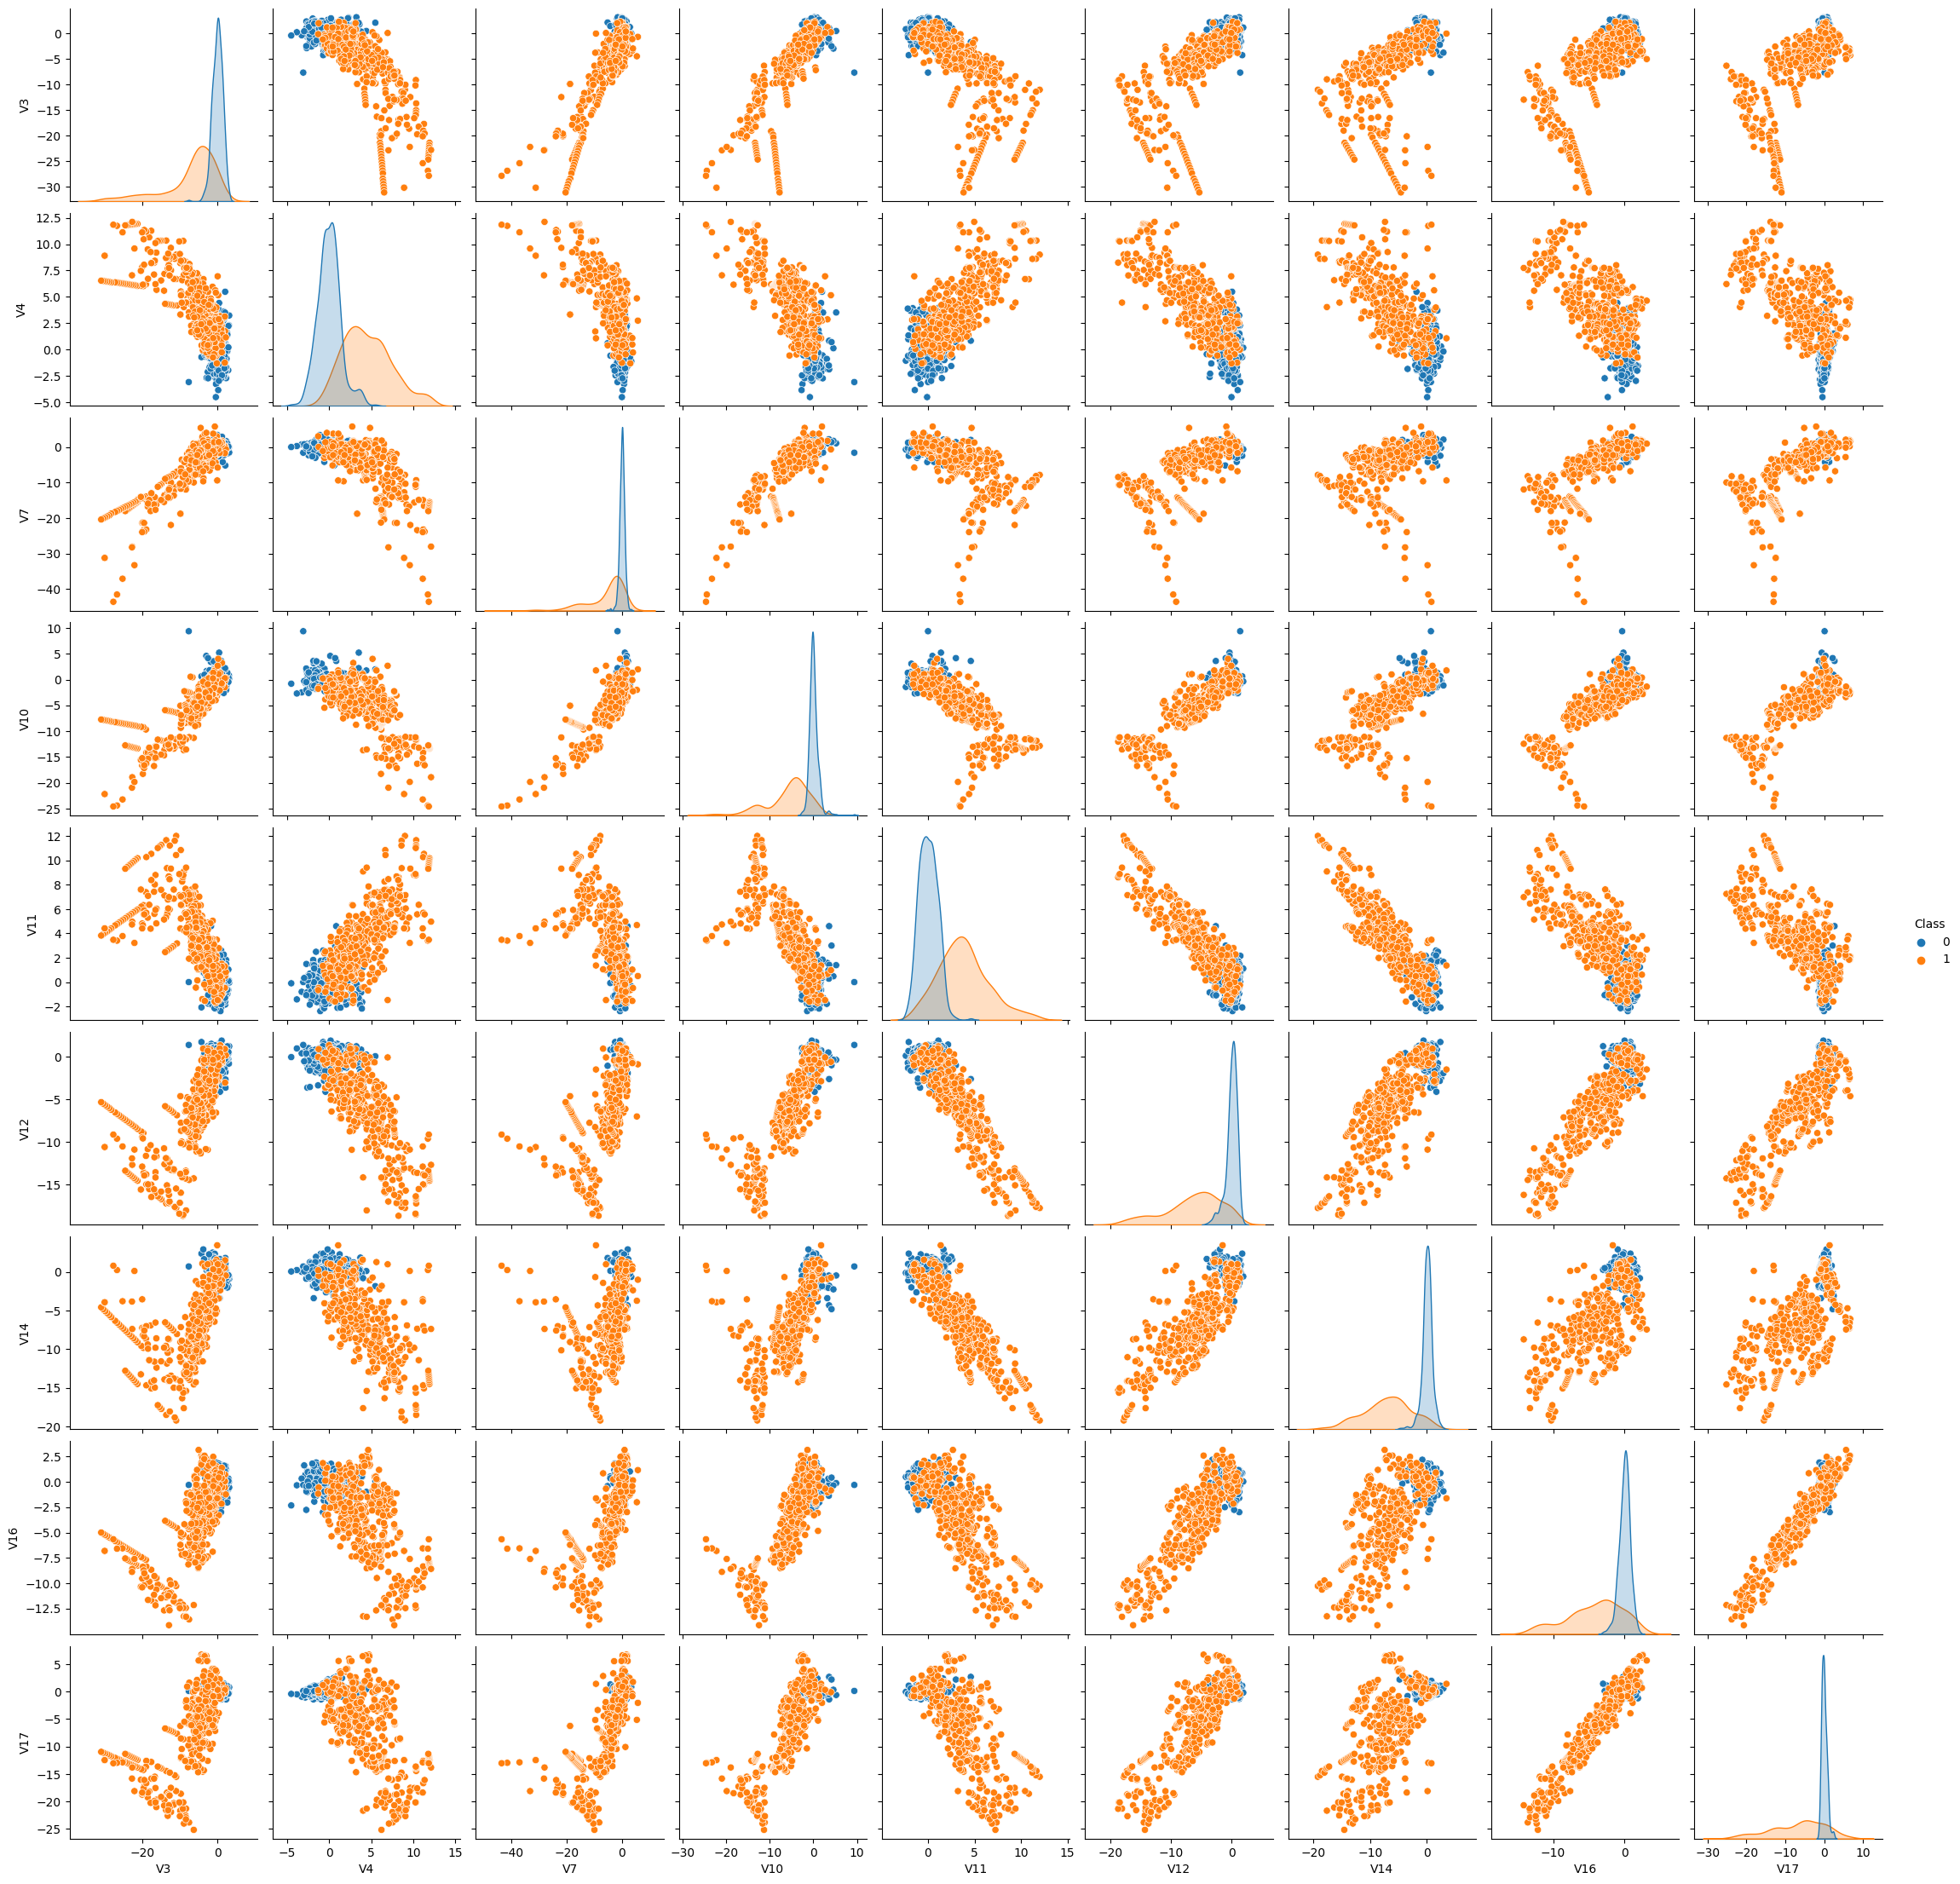

In [53]:
# To ignore all warnings, Pair Plot of all variables
sns.pairplot(downsampled_df, hue='Class')

**Insight**

* Normal transactions(Class 0) have distinct cluster across all variables, whereas fradulent transaction(Class 1) do not stand a specific cluster.
* Fradulent transactions become vary widely, and do not have the consistency for follow the specific patterns.

**Initial Exploration of Models Performance**

In [54]:
# Installation
!pip install lazypredict

In [55]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier

# Separate features and target
X = downsampled_df.drop(columns='Class')
y = downsampled_df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Fit all models
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:02<00:00, 14.25it/s]

[LightGBM] [Info] Number of positive: 394, number of negative: 393
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 787, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500635 -> initscore=0.002541
[LightGBM] [Info] Start training from score 0.002541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LabelSpreading,0.94,0.94,0.94,0.94,0.17
LabelPropagation,0.94,0.94,0.94,0.94,0.15
XGBClassifier,0.93,0.93,0.93,0.93,0.09
LGBMClassifier,0.93,0.93,0.93,0.93,0.12
ExtraTreesClassifier,0.93,0.93,0.93,0.93,0.23
BaggingClassifier,0.93,0.93,0.93,0.93,0.08
RandomForestClassifier,0.92,0.92,0.92,0.92,0.38
Perceptron,0.92,0.92,0.92,0.92,0.02
KNeighborsClassifier,0.92,0.92,0.92,0.92,0.03


**Insight**

* The top three performers are 'LabelSpreading', 'LabelPropagation', and 'XGBClassifier', achieving an impressive accuracy of up to 93% to 94%. 

**LabelSpreading Tuning**

In [56]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Separate features(X) and target(y)
X = downsampled_df.drop('Class', axis=1)
y = downsampled_df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform the LabelSpreading model
model = LabelSpreading()

# Define the parameter grid to search
param_grid = {
    'kernel': ['knn', 'rbf'], # Kernel function to use
    'gamma': ['scale', 'auto', 0.1, 1.0], # Kernel coefficient for 'rbf' and 'poly' kernels
    'alpha': [0.1, 0.2, 0.5, 0.8],  # Clamping factor
    'n_neighbors' : [3, 5, 7] # Numner of neighbots to consider
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Receive the best hyperparameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Hyperparameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_score:.2f}')

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report on the test set
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'alpha': 0.1, 'gamma': 0.1, 'kernel': 'knn', 'n_neighbors': 3}
Best Cross-Validation Accuracy: 0.95

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        99
           1       0.98      0.88      0.92        98

    accuracy                           0.93       197
   macro avg       0.93      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197



**Ensemble Voting: Major Improvement**

In [57]:
#As previously explained, we will include the import statements in the code
#to allow you to use or test different parts of the code separately if needed.
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Separate features(X) and target(y)
X = downsampled_df.drop(columns='Class')
y = downsampled_df['Class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the models
label_spreading = LabelSpreading()
label_propagation = LabelPropagation()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create an ensemble
ensemble = VotingClassifier(estimators=[
    ('label_spreading', label_spreading),
    ('label_propagation', label_propagation),
    ('xgb', xgb)
], voting = 'hard')

# Fit the ensemble to the training data
ensemble.fit(X_train, y_train)

# Make predictions
y_pred = ensemble.predict(X_test)

# Evaluate the performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[97  2]
 [ 5 93]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97        99
           1       0.98      0.95      0.96        98

    accuracy                           0.96       197
   macro avg       0.96      0.96      0.96       197
weighted avg       0.96      0.96      0.96       197



**Insight**
* The accuracy improved by 2%, which is quite significant.

**Enhancing the Ensemble: Tuning Parameters**

In [58]:
#As previously explained, we will include the import statements in the code
#to allow you to use or test different parts of the code separately if needed.
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Separate features and target
X = downsampled_df.drop(columns='Class')
y = downsampled_df['Class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the models
label_spreading = LabelSpreading()
label_propagation = LabelPropagation()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create an ensemble
ensemble = VotingClassifier(estimators=[
    ('label_spreading', label_spreading),
    ('label_propagation', label_propagation),
    ('xgb', xgb)
], voting='hard')

# Define parameter grid for hyperparameter tuning
param_grid = {
    'label_spreading__gamma': [0.1, 0.5, 1.0, 5.0, 10.0],
    'label_propagation__gamma': [0.1, 0.5, 1.0, 5.0, 10.0],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.2]
}

# Perform grid search
grid_search = GridSearchCV(estimator=ensemble, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'label_propagation__gamma': 0.1, 'label_spreading__gamma': 10.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
Best Cross-Validation Score: 0.9352015789626448
Confusion Matrix:
[[99  0]
 [ 8 90]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        99
           1       1.00      0.92      0.96        98

    accuracy                           0.96       197
   macro avg       0.96      0.96      0.96       197
weighted avg       0.96      0.96      0.96       197



**Insight**
We didn't observe a notable improvement in metrics with the tuned parameters; nevertheless, we will retain these values for our final model.

**Minimizing False Negatives: A Crucial Step**

In [59]:
#As previously explained, we will include the import statements in the code
#to allow you to use or test different parts of the code separately if needed.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Separate features and target
X = downsampled_df.drop(columns='Class')
y = downsampled_df['Class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the models
label_spreading = LabelSpreading()
label_propagation = LabelPropagation()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create an ensemble
ensemble = VotingClassifier(estimators=[
    ('label_spreading', label_spreading),
    ('label_propagation', label_propagation),
    ('xgb', xgb)
], voting='soft')  # Use soft voting for probability output

# Fit the ensemble to the training data
ensemble.fit(X_train, y_train)

# Make predictions with probabilities
y_prob = ensemble.predict_proba(X_test)[:, 1]  # Probability of being class 1 (fraud)

# Adjust threshold
threshold = 0.26  # threshold
y_pred_adjusted = (y_prob >= threshold).astype(int)

# Evaluate the performance
print("Confusion Matrix with Adjusted Threshold:")
print(confusion_matrix(y_test, y_pred_adjusted))
print("\nClassification Report with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))

Confusion Matrix with Adjusted Threshold:
[[96  3]
 [ 3 95]]

Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        99
           1       0.97      0.97      0.97        98

    accuracy                           0.97       197
   macro avg       0.97      0.97      0.97       197
weighted avg       0.97      0.97      0.97       197



**Insight**
* In the previous model, we had FN = 8, which is quite high considering this is a fraud detection problem. 
* In this new model, we utilized predictions with probabilities and set a threshold of 0.26. 
* This approach reduced the FN from 8 to 3, marking a significant improvement. Moreover, this method also increased the accuracy to 97%

**Adjusting Probability Thresholds for Better Detection**

In [60]:
#As previously explained, we will include the import statements in the code
#to allow you to use or test different parts of the code separately if needed.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Assume downsampled_df is already loaded with features and target column
# Separate features and target
X = downsampled_df.drop(columns='Class')
y = downsampled_df['Class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the models with best hyperparameters
label_spreading = LabelSpreading(alpha=0.1, gamma=0.1, kernel='knn', n_neighbors=3)
label_propagation = LabelPropagation()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create an ensemble with adjusted threshold
FRAUDFIGHTER = VotingClassifier(estimators=[
    ('label_spreading', label_spreading),
    ('label_propagation', label_propagation),
    ('xgb', xgb)
], voting='soft')  # Use soft voting for probability output

# Fit the ensemble to the training data
FRAUDFIGHTER.fit(X_train, y_train)

# Make predictions with probabilities
y_prob = FRAUDFIGHTER.predict_proba(X_test)[:, 1]  # Probability of being class 1 (fraud)

# Adjust threshold (e.g., 0.371)
threshold = 0.371
y_pred_adjusted = (y_prob >= threshold).astype(int)

# Evaluate the performance
print("Confusion Matrix with Adjusted Threshold:")
print(confusion_matrix(y_test, y_pred_adjusted))
print("\nClassification Report with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))

Confusion Matrix with Adjusted Threshold:
[[97  2]
 [ 3 95]]

Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        99
           1       0.98      0.97      0.97        98

    accuracy                           0.97       197
   macro avg       0.97      0.97      0.97       197
weighted avg       0.97      0.97      0.97       197



**Insight**
* We present FRAUDFIGHTER, our final model, which incorporates the following: - Ensemble method using three algorithms: LabelSpreading, LabelPropagation, XGBClassifier. 
* Utilization of tuned hyperparameters obtained previously. 
* Introduction of a new threshold parameter for predictions with probabilities (threshold = 0.371). 
* FRAUDFIGHTER achieved a high accuracy of 97% with only 3 false negatives (FN). It's worth noting that the number of false positives (FP) in this model was also reduced from 3 to 2. 
* The weighted average precision, recall, and F1 score all equaled 97%, demonstrating the robustness and effectiveness of this model.

**Conclusions**

* Effective Model Development: Through meticulous data preprocessing, feature selection, and model optimization steps, we've developed a robust fraud detection model.

* Importance of Imbalance Handling: Addressing the imbalance in the dataset was critical. Downsampling the majority class improved model performance by ensuring balanced representation of fraudulent and non-fraudulent transactions.

* Model Performance: Our final model, FRAUDFIGHTER, achieved an impressive accuracy of 97% with minimal false negatives and false positives. This underscores its capability to accurately detect fraudulent transactions.

* Threshold Optimization: Fine-tuning the threshold for probability predictions significantly enhanced the model's sensitivity in detecting fraudulent activities, reducing false negatives and improving overall accuracy.

* Ensemble Approach: Leveraging an ensemble method with carefully selected algorithms (LabelSpreading, LabelPropagation, XGBClassifier) proved effective in boosting predictive performance and robustness.

* Real-world Application: The methodologies and techniques applied here are crucial for real-world applications, where the cost of misclassifying fraudulent transactions can be substantial both financially and in terms of trust and customer satisfaction.

* Future Directions: Further enhancements could involve exploring advanced feature engineering techniques, integrating additional data sources, or deploying the model in a real-time environment to continuously improve fraud detection capabilities.